#### Importing the neccessary packages

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from time import process_time
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
# Importing the datasets
url_df_1 = pd.read_csv('data.csv')
url_df_2 = pd.read_csv('phishing_site_urls.csv')

## Exploratory Data Analysis

In [3]:
url_df_1.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


In [4]:
url_df_2.head(10)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
5,smilesvoegol.servebbs.org/voegol.php,bad
6,premierpaymentprocessing.com/includes/boleto-2...,bad
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad
8,super1000.info/docs,bad
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad


In [5]:
# Checking for null values in the datasets
print(url_df_1.isnull().values.any())
print(url_df_2.isnull().values.any())


#In case of null value we will fill the null values with mean: 
def dataImputation(data,key):
    data = data.fillna(data[key].mean())
    return data;

False
False


In [6]:
# Total Entries in both datasets
print(url_df_1.shape)
print(url_df_2.shape)
print(url_df_1['label'].count() + url_df_2['Label'].count())

(420464, 2)
(549346, 2)
969810


### Merging the two datasets

In [7]:
# Renaming the columns in the second dataset so that they match with the first one
url_df_2 = url_df_2.rename(columns={'URL': 'url', 'Label': 'label'})
# url_df = pd.merge(url_df_1, url_df_2)
url_df = pd.concat([url_df_1,url_df_2]).drop_duplicates().reset_index(drop=True)

In [8]:
url_df.shape

(507197, 2)

In [9]:
url_df.describe()

,url,label
count,507197,507197
unique,507196,2
top,tommyhumphreys.com/,good
freq,2,392897


In [10]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507197 entries, 0 to 507196
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     507197 non-null  object
 1   label   507197 non-null  object
dtypes: object(2)
memory usage: 7.7+ MB


The number of good URLs in the dataset is: 392897
The number of bad URLs in the dataset is: 114300


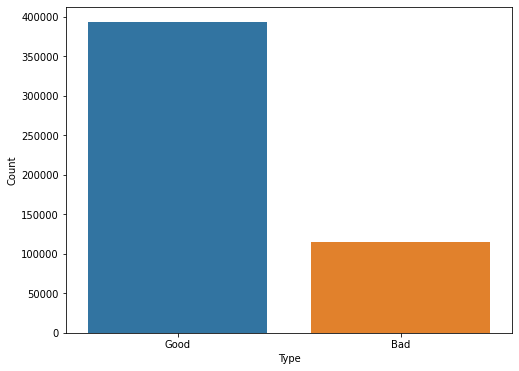

In [11]:
# Visualising our data

figure(figsize=(8, 6))
print(f"The number of good URLs in the dataset is: {url_df['label'].where(url_df['label'] == 'good').count()}")
print(f"The number of bad URLs in the dataset is: {url_df['label'].where(url_df['label'] == 'bad').count()}")
plot = sns.barplot(x = ['Good', 'Bad'], y = url_df['label'].value_counts())
plot.set(xlabel='Type', ylabel='Count')
plt.show();

We can see that the number of Good URLs is far more than Bad URLs in our dataset and that makes our data <b>imbalanced</b> we can try resampling to solve this particular issue.

In [12]:
good_urls = url_df[url_df['label'] == 'good']
bad_urls = url_df[url_df['label'] == 'bad']

In [13]:
good_urls.head(10)

,url,label
37044,01453.com/,good
37045,015fb31.netsolhost.com/bosstweed.html,good
37046,02bee66.netsolhost.com/lincolnhomepage/,good
37047,02ec0a3.netsolhost.com/getperson.php?personID=...,good
37048,032255.com/,good
37049,05minute.com/,good
37050,07090.blogspot.com/2011/07/westfield-police-of...,good
37051,08nrc.blogspot.com/,good
37052,0creditcard.biz/,good
37053,0dayreggaedancehall.blogspot.com/,good


In [14]:
bad_urls.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


## Data Preprocessing



In [15]:
url_df.sample(20)

,url,label
106451,listofcitiesandcounties.com/list_of_cities_and...,good
197383,capitolhillseattle.com/2011/08/02/atlas-shrug-...,good
351179,tv-eh.com/2011/06/13/family-channel-and-disney...,good
125999,photobucket.com/images/Taylor+Matheny/,good
388366,lanotes.com/images/headers/korp/cp.php?m=login,bad
314894,pressking.com/media-contact-database/ca/c,good
176262,amazon.com/phrase/Ben-Weider,good
200668,cfmb.ch/,good
200290,census-online.us/view/NESBITT/,good
232921,fanbase.com/Steve-Barrere,good


#### Taking a quick look at the sample of our dataset we can see there are a lot of redundant things in our URL like '/ ',  ' : ',  ' . ', etc. these symbols are not neccessary for us. Further in the project we will be using TD-IDF Vectorizer to give scores to these URLs based on their lexical features. It will be a good if we will extract these words from the URL and remove all the redundant characters from it.


In [16]:
tknizer = RegexpTokenizer(r'[A-Za-z]+')

In [17]:
#Testing on a random URL
tknizer.tokenize('http://localhost:8888/notebooks/Documents/Malicious%20URL%20Detection/URL%20Detection%20using%20Python.ipynb')

['http',
 'localhost',
 'notebooks',
 'Documents',
 'Malicious',
 'URL',
 'Detection',
 'URL',
 'Detection',
 'using',
 'Python',
 'ipynb']

Defining a small function to form a new column in our dataframe that contains the tokenized URLs 

In [18]:
def tokenizeUrl(url):
    return tknizer.tokenize(url)

start = process_time()
print('Starting the process to tokenize the URLs...')

# Creating a new column in our dataframe that keeps the tokenized form of the URLs
url_df['tokenized_url'] = url_df.url.map(tokenizeUrl)
end = process_time()
print(f'Process Finished! and took {end - start}s')

Starting the process to tokenize the URLs...
Process Finished! and took 2.328125s


In [19]:
url_df.head(5)

,url,label,tokenized_url
0,diaryofagameaddict.com,bad,"[diaryofagameaddict, com]"
1,espdesign.com.au,bad,"[espdesign, com, au]"
2,iamagameaddict.com,bad,"[iamagameaddict, com]"
3,kalantzis.net,bad,"[kalantzis, net]"
4,slightlyoffcenter.net,bad,"[slightlyoffcenter, net]"


We only need the words of the URL not the commas that are seperating them in the list so we will define a function that removes the commas and append that as a new column 
in our Dataframe.

In [20]:
def clean_token(token):
    return ' '.join(token);

url_df['tokenized_url_cleaned'] = url_df['tokenized_url'].map(clean_token)

In [21]:
url_df.sample(10)

,url,label,tokenized_url,tokenized_url_cleaned
469624,www.cc.gatech.edu/aimosaic/faculty/goel/,good,"[www, cc, gatech, edu, aimosaic, faculty, goel]",www cc gatech edu aimosaic faculty goel
338621,summerdiscovery.com/,good,"[summerdiscovery, com]",summerdiscovery com
86145,finance.kelso.gov/City_of_Kelso_WA_Finance_Dep...,good,"[finance, kelso, gov, City, of, Kelso, WA, Fin...",finance kelso gov City of Kelso WA Finance Dep...
198654,cbc.ca/spark/2008/01/unedited-interview-with-a...,good,"[cbc, ca, spark, unedited, interview, with, al...",cbc ca spark unedited interview with alex stef...
126126,photos.lucywho.com/cliff-arquette-photos-t5149...,good,"[photos, lucywho, com, cliff, arquette, photos...",photos lucywho com cliff arquette photos t html
285508,menuism.com/restaurants/kris-kates-ice-cream-t...,good,"[menuism, com, restaurants, kris, kates, ice, ...",menuism com restaurants kris kates ice cream t...
288538,mmamania.com/2008/09/15/david-loiseau-inches-c...,good,"[mmamania, com, david, loiseau, inches, closer...",mmamania com david loiseau inches closer to uf...
142084,streaming--tv.com/puerto-rico-islanders-v-sain...,good,"[streaming, tv, com, puerto, rico, islanders, ...",streaming tv com puerto rico islanders v saint...
345873,tikun.ca/en/cat/federationcja/how-your-donatio...,good,"[tikun, ca, en, cat, federationcja, how, your,...",tikun ca en cat federationcja how your donatio...
283868,matchcollege.com/college/199120/University-of-...,good,"[matchcollege, com, college, University, of, N...",matchcollege com college University of North C...


## TF-IDF Vectorizer
We are using TF-IDF algorithm to transform our tokenized_urls into numerical representation that we further use in our Machine learning algorithm to make predictions. 



In [22]:
vectorizer = TfidfVectorizer();

start = process_time()
print('Vectorizing URLs...')
url_names = vectorizer.fit_transform(url_df.tokenized_url_cleaned)
end = process_time()
print(f'Task Complete! and took {end - start}s')

Vectorizing URLs...
Task Complete! and took 4.703125s


In [23]:
print(url_names)

  (0, 63362)	0.09925989975711395
  (0, 81754)	0.9950615419662282
  (1, 21257)	0.39068637641562304
  (1, 101040)	0.9159778799029434
  (1, 63362)	0.09137110490597747
  (2, 147412)	0.9950615419662282
  (2, 63362)	0.09925989975711395
  (3, 221298)	0.2799929475489598
  (3, 169685)	0.9600020569367783
  (4, 293180)	0.9600020569367783
  (4, 221298)	0.2799929475489598
  (5, 319915)	0.9950615419662282
  (5, 63362)	0.09925989975711395
  (6, 325043)	0.9950615419662282
  (6, 63362)	0.09925989975711395
  (7, 140983)	0.5975473955006156
  (7, 155814)	0.8018335925430106
  (8, 103330)	0.28465190890071357
  (8, 239645)	0.41432622837353766
  (8, 247315)	0.14797423343187988
  (8, 154091)	0.382212337742083
  (8, 320623)	0.45201911914126386
  (8, 332413)	0.20421639991275892
  (8, 68799)	0.5773203619277139
  (9, 178525)	0.8187156226973928
  :	:
  (507193, 355657)	0.44497484381538777
  (507193, 354709)	0.1681294249584026
  (507193, 3676)	0.35735522366398786
  (507193, 63362)	0.0683570620746211
  (507194, 34922

### Splitting the data for training and testing

In [24]:
trainX, testX, trainY, testY = train_test_split(url_names, url_df.label)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(380397, 369586)
(380397,)
(126800, 369586)
(126800,)


# MODELLING

In [25]:
# An array to store the scores of both models
model_scores = []

## 1. Logistic Regression
The first classification algorithm we used is <b>Logistic Regression</b>
<br>
We will be using two algorithms on this data and will deploy our model with the better performing one.

In [26]:
logreg = LogisticRegression(max_iter=600)

In [27]:
print('********************************************************')
print('Applying Logistic Regression...')
start = process_time()
logreg.fit(trainX, trainY)
end = process_time()
print(f'Model is trained. It took {end - start} seconds to train the model!')
print('********************************************************')

********************************************************
Applying Logistic Regression...
Model is trained. It took 32.03125 seconds to train the model!
********************************************************


In [28]:
print(f'The model has a {logreg.score(trainX, trainY) * 100:.2f}% Training accuracy')
print(f'The model has a {logreg.score(testX, testY) * 100:.2f}% Testing accuracy')
# Appending the logistic regression model score to our list
model_scores.append(logreg.score(testX, testY))

The model has a 96.82% Training accuracy
The model has a 95.80% Testing accuracy


### Confusion Matrix for Logistic Regression
Using the confusion matrix we can visualise that how accurate our model is

Classification Matrix for the model is: 



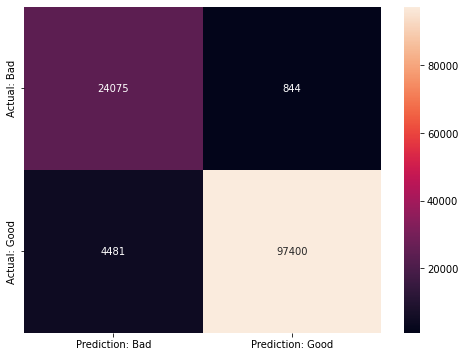

In [29]:
conf_mat = pd.DataFrame(confusion_matrix(logreg.predict(testX), testY), columns = ['Prediction: Bad', 'Prediction: Good'], index = ['Actual: Bad', 'Actual: Good'])
print('Classification Matrix for the model is: \n')
figure(figsize = (8, 6))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.show();

## 2. Random Forest
The Second classification algorithm we used is <b>Random Forest</b>
<br>

In [30]:
rf = RandomForestClassifier(n_estimators=1,max_depth=2,random_state=0)

In [31]:
print('********************************************************')
print('Applying Random forest algorithm ...')
start = process_time()
rf.fit(trainX, trainY)
end = process_time()
print(f'Model is trained. It took {end - start} seconds to train the model!')
print('********************************************************')

********************************************************
Applying Random forest algorithm ...
Model is trained. It took 0.859375 seconds to train the model!
********************************************************


In [32]:
score = rf.score(trainX,trainY)
print(score)

0.7747905477698299


In [33]:
score = rf.score(testX,testY)
print(score)

0.7750315457413249


### We implemented our random forest with  estimator trees . It may be not the max accuracy , So we will iterate for 2-5 estimators and check for maximum 


In [34]:
acc_lst = []
for i in range(1,4):
    acc = cross_val_score(RandomForestClassifier(n_estimators=i,max_depth=2,criterion='entropy'),trainX,trainY,cv=5).mean()
    print(acc)
    acc_lst.append(acc)

0.7760602764401922
0.7772116983827577
0.7745933853361155


[0.7760602764401922, 0.7772116983827577, 0.7745933853361155]


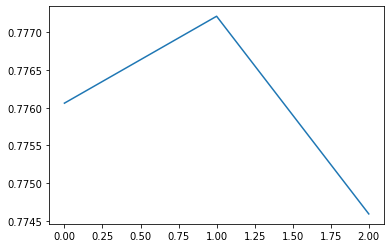

In [35]:
print(acc_lst)
plt.plot(acc_lst)
mx = np.argmax(acc_lst)
plt.show()

### If we calculate this for 20-30 estimator tree tree will be more randomised and we will choose the point where it gave maximum accuracy 

In [36]:
# We got the maximum n_estimator point now (:
# print(mx)
rf = RandomForestClassifier(n_estimators = 2,max_depth=3,criterion='entropy')
rf.fit(trainX,trainY)

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=2)

In [37]:
print(f'The model has a {rf.score(trainX,trainY) * 100:.2f}% Training accuracy')
print(f'The model has a {rf.score(testX,testY) * 100:.2f}% Testing accuracy')

The model has a 77.56% Training accuracy
The model has a 77.58% Testing accuracy


Classification Matrix for the model is: 



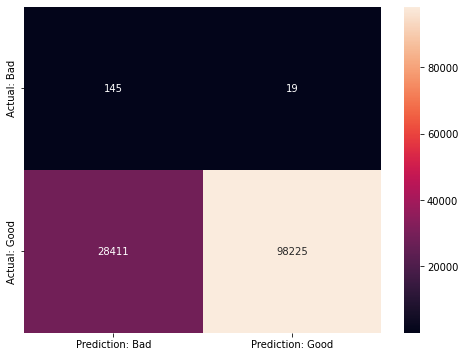

In [38]:
conf_matRF = pd.DataFrame(confusion_matrix(rf.predict(testX), testY), columns = ['Prediction: Bad', 'Prediction: Good'], index = ['Actual: Bad', 'Actual: Good'])
print('Classification Matrix for the model is: \n')
figure(figsize = (8, 6))
sns.heatmap(conf_matRF, annot = True, fmt = 'd')
plt.show();

### We can see that Logistic Regression performs better than Random Forest Classfier on our dataset so we will dump our model as pickel file

In [39]:
pipeline_logreg = make_pipeline(TfidfVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize), LogisticRegression(max_iter=600))

In [40]:
trainX, testX, trainY, testY = train_test_split(url_df.url, url_df.label)

In [41]:
print('*******************************************')
print('Training...')
pipeline_logreg.fit(trainX,trainY)
print('Process Finished')
print('*******************************************')

*******************************************
Training...


c:\python 3.9.0\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Process Finished
*******************************************


In [42]:
print(f'The accuracy is: {pipeline_logreg.score(testX, testY)}')

The accuracy is: 0.9594637223974763


In [43]:
pickle.dump(pipeline_logreg,open('logreg.pkl','wb'))

In [44]:
loaded_logreg = pickle.load(open('logreg.pkl', 'rb'))
res = loaded_logreg.score(testX, testY)
print(res)

0.9594637223974763


In [45]:
url = ['stackoverflow.com/questions/']
res = loaded_logreg.predict(url)
print(res)

['good']
